# Comparing different types of vector search using Faiss, cuVS, CuPy and optimizing it with the help of NVIDIA Nsight Systems

This notebook explores the optimization of vector search operations by comparing different implementations, including Faiss, cuVS, and CuPy. Using NVIDIA Nsight Systems, it profiles and analyzes performance bottlenecks to guide efficient GPU-accelerated search strategies. The experiments focus on improving the speed and scalability of nearest neighbor searches, a critical component in many machine learning and information retrieval applications.

In [ ]:
# We check if GPU is available and the CUDA version
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
CUDA version:  11.8
GPU: NVIDIA RTX 2000 Ada Generation Laptop GPU


## Loading first dataset

For testing things locally we will use ArguAna (https://aclanthology.org/P18-1023.pdf, https://webis.de/data/arguana-counterargs.html), one of datasets available through
BEIR (A Heterogeneous Benchmark for Zero-shot Evaluation of Information Retrieval Models: https://openreview.net/forum?id=wCu6T5xFjeJ).

In [2]:
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from transformers import AutoTokenizer
import onnxruntime as ort
from tqdm import tqdm
import time
import numpy as np
import faiss
import os

dataset = "arguana"
# url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset}.zip"
data_path = os.path.join("datasets", dataset)
# util.download_and_unzip(url, "datasets")

/home/ggatej/miniconda3/envs/avkp1/lib/python3.10/site-packages/beir/util.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Each dataset from BEIR is composed out of 'corpus', 'queries' and 'qrels' entries. The 'corpus' and 'queries' in ArguAna both contain argumentative text,
that was scraped from an online debate portal. 'qrels' represent mappings between both of the texts that tell us if the corpus (i.e. document) text 
is relevant to the query (i.e. if claims in the document are relevant considering the arguments in the query).

Let's gain a better understanding of this by looking at a couple of examples of pairs from the test set that are deemed relevant.

In [3]:
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

relevant_pairs = [
    (qid, docid)
    for qid, docs in qrels.items()
    for docid, score in docs.items()
    if score == 1
]

for qid, docid in relevant_pairs[:5]:
    print(f"Query ID: {qid}")
    print(f"Query: {queries[qid]}")
    print(f"Document ID: {docid}")
    print(f"Document Text: {corpus[docid]['text']}")
    print("-" * 100)

# Collect all relevant doc IDs
relevant_doc_ids = set(
    docid
    for docs in qrels.values()
    for docid in docs.keys()
)

# Use only relevant doc IDs to select doc_texts
doc_ids = [docid for docid in relevant_doc_ids if docid in corpus]
doc_texts = [corpus[docid]["text"] for docid in doc_ids]

100%|██████████| 8674/8674 [00:00<00:00, 177295.51it/s]

Query ID: test-environment-aeghhgwpe-pro02a
Query: Being vegetarian helps the environment  Becoming a vegetarian is an environmentally friendly thing to do. Modern farming is one of the main sources of pollution in our rivers. Beef farming is one of the main causes of deforestation, and as long as people continue to buy fast food in their billions, there will be a financial incentive to continue cutting down trees to make room for cattle. Because of our desire to eat fish, our rivers and seas are being emptied of fish and many species are facing extinction. Energy resources are used up much more greedily by meat farming than my farming cereals, pulses etc. Eating meat and fish not only causes cruelty to animals, it causes serious harm to the environment and to biodiversity. For example consider Meat production related pollution and deforestation  At Toronto’s 1992 Royal Agricultural Winter Fair, Agriculture Canada displayed two contrasting statistics: “it takes four football fields of 

Looking at the first of the examples we can see the claim being made is that "being vegetarian helps the environment", while the relevant document questions this claim.
We will be precomputing embeddings of the document texts.

## Generating embeddings

To generate embeddings we'll use an ONNX-optimized version
of the smaller model from the GTE or General Text Embeddings family (https://arxiv.org/pdf/2308.03281). 

In [4]:
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")

def encode_onnx(texts, session, tokenizer, batch_size=64):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="np",
            padding="max_length",
            max_length=128,
            truncation=True,
            return_token_type_ids=True
        )
        outputs = session.run(None, {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "token_type_ids": inputs["token_type_ids"]
        })
        batch_embeds = outputs[0][:, 0, :]  # CLS token
        embeddings.append(batch_embeds)
    return np.vstack(embeddings)

We do inference on both CPU and GPU, so we can compare the execution times.

In [5]:
print("Encoding with CPU ONNX model...")
session_cpu = ort.InferenceSession("model.onnx", providers=["CPUExecutionProvider"])

start_cpu = time.time()
doc_embeddings = encode_onnx(doc_texts, session_cpu, tokenizer)
end_cpu = time.time()

print(f"CPU encoding done in {end_cpu - start_cpu:.2f} seconds")

Encoding with CPU ONNX model...


Embedding: 100%|██████████| 22/22 [00:28<00:00,  1.28s/it]

CPU encoding done in 28.12 seconds


In [6]:
print("\nEncoding with GPU ONNX model...")
session_gpu = ort.InferenceSession("model.onnx", providers=["CUDAExecutionProvider"])

start_gpu = time.time()
doc_embeddings = encode_onnx(doc_texts, session_gpu, tokenizer)
end_gpu = time.time()

# We save the embeddings for later reuse
np.save("doc_embeddings_arg.npy", doc_embeddings)
print("Saved doc_embeddings_arg.npy")
print(f"GPU encoding done in {end_gpu - start_gpu:.2f} seconds")

2025-04-21 06:24:53.693659926 [W:onnxruntime:, session_state.cc:1030 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-21 06:24:53.693677366 [W:onnxruntime:, session_state.cc:1032 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.



Encoding with GPU ONNX model...


Embedding: 100%|██████████| 22/22 [00:01<00:00, 11.85it/s]

Saved doc_embeddings_arg.npy
GPU encoding done in 1.86 seconds


As expected the inference performed on GPU finished much quicker.

Let's perform a similar experiment by using KNN brute force algorithm to use the vectors for performing search over our data.

## Vector search using Faiss and cuVS

We will first use Faiss - a library that contains 
algorithms for clustering dense vectors and performing efficient similarity search. It will provide a solid baseline for comparing the rest 
of our implementations. To search with Faiss we need to build an index. Since we will be using brute-force
nearest neighbor search, building an index is mainly just an act of storing data to RAM`*`. 
The distances between vectors will be computed using squared Euclidean distance.
While this method is exact it comes at the cost of speed and memory.

We'll be interested to show how the performance on CPU compares itself to the GPU optimised variant of the same
algorithm. For this we'll be using cuVS, which is a library that was developed by NVIDIA
for performing the same kind of operations on vectors as Faiss, but using highly optimied CUDA kernels
(note that Faiss also comes in a GPU optimised variant and provides integration with cuVS, but this won't be covered here).

`*` In the general case, indexing represents more than this and is connected with the process of storing the dataset in memory more efficiently,
which also can evolve a lot of computing.
In our case the computing (||query - xˇi||ˇ₂ for each xˇi) is performed only in the search process.
When we query the index all distances between the query vector and each of the document vectors
are calculated on the fly. While we could calculate a distance matrix of all pairs of vectors and store it,
this is not very practical, since it would cost a lot of space (O(n^2)) and would also make
sense only in search cases where the query vector would already be part of the distance matrix.

In [7]:
import cupy as cp
import numpy as np
from cuvs.common import Resources
# https://docs.rapids.ai/api/cuvs/stable/indexes/bruteforce/
# https://docs.rapids.ai/api/cuvs/stable/python_api/neighbors_brute_force/
from cuvs.neighbors import brute_force
import matplotlib.pyplot as plt

# Load embeddings for building gpu index
# doc_embeddings_gpu = np.load("doc_embeddings_arg.npy")

We normally expect the search via GPU to be faster. Let's also do a simple sanity check and see if we get
the right results performing search.

For sake of simplicity we pick a single query and see what document is the one we'll
hope to find towards the top of our search results. 

In [8]:
qid, docid = relevant_pairs[2]
query_text = queries[qid]
correct_doc_text = corpus[docid]["text"]

print("Selected Query:", query_text)
print("Relevant Document Text:", correct_doc_text[:300], "...")

Selected Query: Vegetarianism is healthier  There are significant health benefits to 'going veggie'; a vegetarian diet contains high quantities of fibre, vitamins, and minerals, and is low in fat. (A vegan diet is even better since eggs and dairy products are high in cholesterol.) The risk of contracting many forms of cancer is increased by eating meat: in 1996 the American Cancer Society recommended that red meat should be excluded from the diet entirely. Eating meat also increases the risk of heart disease - vegetables contain no cholesterol, which can build up to cause blocked arteries in meat-eaters. An American study found out that: “that men in the highest quintile of red-meat consumption — those who ate about 5 oz. of red meat a day, roughly the equivalent of a small steak had a 31% higher risk of death over a 10-year period than men in the lowest-consumption quintile, who ate less than 1 oz. of red meat per day, or approximately three slices of corned beef.” [1] A vegetarian di

In [9]:
# We embed the query and run our two searches.
query_embedding = encode_onnx([query_text], session_gpu, tokenizer)
np.save("query_embedding_arg.npy", query_embedding)

# Build FAISS CPU index (just storing data to RAM).
index_cpu = faiss.IndexFlatL2(doc_embeddings.shape[1])
index_cpu.add(doc_embeddings)

Embedding: 100%|██████████| 1/1 [00:00<00:00, 184.14it/s]


In [10]:
%%time

distances, indices = index_cpu.search(query_embedding.astype(np.float32), k=3)

CPU times: user 346 μs, sys: 4 μs, total: 350 μs
Wall time: 207 μs


In [11]:
print("\nFAISS CPU top-3 results:")
for rank, idx in enumerate(indices[0]):
    print(f"Rank {rank+1}:")
    print(doc_texts[idx][:300], "...\n")


FAISS CPU top-3 results:
Rank 1:
The key to good health is a balanced diet, not a meat- and fish-free diet. Meat and fish are good sources of protein, iron, and other vitamins and minerals. Most of the health benefits of a vegetarian diet derive from its being high in fibre and low in fat and cholesterol. These can be achieved by a ...

Rank 2:
Human evolved as omnivores over thousands of years. Yet since the invention of farming there is no longer a need for us to be omnivores. Even if we wished to we could no longer collect, hunt and eat our food in the same way as our ancestors as we could not support the human population. We have outst ...

Rank 3:
The problems with fatigue, apathetic behaviour and concentration are mostly a result from a lack of iron in the diet. However as with any diet this is only a problem when not eating the right things, this regularly means that such iron deficiency can be a problem in the developing world where vegeta ...



In [12]:
# # Convert to cuDF DataFrame (GPU-backed)
doc_embeddings_gpu = cp.asarray(doc_embeddings)
query_embedding_gpu = cp.asarray(query_embedding)

# Build cuVS index
index_gpu = brute_force.build(
    dataset=doc_embeddings_gpu,
    metric="euclidean",
    metric_arg=2.0,
    resources=None
)

In [13]:
%%time

distances, indices = brute_force.search(
    index=index_gpu,
    queries=query_embedding_gpu,
    k=3,
    resources=None
)

CPU times: user 1.01 ms, sys: 1.99 ms, total: 3 ms
Wall time: 2.76 ms


In [14]:
# Convert to NumPy arrays
distances = cp.asnumpy(distances)
indices = cp.asnumpy(indices)

# Print top-3 results
print("\ncuVS GPU top-3 results:")
for rank, idx in enumerate(indices[0]):
    print(f"Rank {rank+1}:")
    print(doc_texts[idx][:300], "...\n")


cuVS GPU top-3 results:
Rank 1:
The key to good health is a balanced diet, not a meat- and fish-free diet. Meat and fish are good sources of protein, iron, and other vitamins and minerals. Most of the health benefits of a vegetarian diet derive from its being high in fibre and low in fat and cholesterol. These can be achieved by a ...

Rank 2:
Human evolved as omnivores over thousands of years. Yet since the invention of farming there is no longer a need for us to be omnivores. Even if we wished to we could no longer collect, hunt and eat our food in the same way as our ancestors as we could not support the human population. We have outst ...

Rank 3:
The problems with fatigue, apathetic behaviour and concentration are mostly a result from a lack of iron in the diet. However as with any diet this is only a problem when not eating the right things, this regularly means that such iron deficiency can be a problem in the developing world where vegeta ...



We can see that in both cases we end up with the same retrieval results, but surprisingly find the search utilising the GPU is slower. This is because for smaller datasets the cost of moving data to the GPU and setting it up outweigh the benefits of parallelism. What this tells us is that performance wise, inherently one type of search isn't better than the other, but it all depends on the size of data we are dealing with. 

## Using a bigger dataset

If we want the GPU to justify the overhead we need a larger dataset, so it can utilise its parallel architecture. Let's load the BEIR version of the DBpedia-Entity dataset (https://github.com/iai-group/DBpedia-Entity) to repeat our test and demonstrate this.

In [15]:
import cupy as cp
import numpy as np
import os
from beir.datasets.data_loader import GenericDataLoader

dataset = "dbpedia-entity"
# url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_dbpedia_entity}.zip"
data_path = os.path.join("datasets", dataset)
# util.download_and_unzip(url, "datasets")

corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

relevant_pairs = [
    (qid, docid)
    for qid, docs in qrels.items()
    for docid, score in docs.items()
    if score == 1
]

for qid, docid in relevant_pairs[40:45]:
    print(f"Query ID: {qid}")
    print(f"Query: {queries[qid]}")
    print(f"Document ID: {docid}")
    print(f"Document Text: {corpus[docid]['text']}")
    print("-" * 100)

# This time we extract text from entire corpus ...
doc_texts = [doc["text"] for doc in corpus.values()]
# ... and pick the first 75000 entries.
doc_texts = doc_texts[:75_000]

session_gpu = ort.InferenceSession("model.onnx", providers=["CUDAExecutionProvider"])

start_gpu = time.time()
doc_embeddings = encode_onnx(doc_texts, session_gpu, tokenizer)
end_gpu = time.time()

np.save("doc_embeddings_dbpe.npy", doc_embeddings)
print("Saved doc_embeddings_dbpe.npy")
print(f"GPU encoding done in {end_gpu - start_gpu:.2f} seconds")

# Since the dbpedia-entity dataset consists of multiple relevant documents per query we'll embed a custom query.
query = "iconic archaeological landmark"
query_embedding = encode_onnx(query, session_gpu, tokenizer)
np.save("query_embedding_dbpe.npy", query_embedding)

100%|██████████| 4635922/4635922 [00:14<00:00, 326531.49it/s]


Query ID: INEX_LD-2009039
Query: roman architecture
Document ID: <dbpedia:Campus_Agrippae>
Document Text: The Campus Agrippae is the area within the boundaries of ancient Rome named after Marcus Vipsanius Agrippa. A number of construction projects were developed within its perimeters, including the Porticus Vipsania, built by his sister, Vipsania Polla, and finished by Augustus, which ran along the western perimeter, against the Via Lata. There was also a race course.
----------------------------------------------------------------------------------------------------
Query ID: INEX_LD-2009039
Query: roman architecture
Document ID: <dbpedia:Cella>
Document Text: A cella (from Latin for small chamber) or naos (from the Greek ναός, "temple"), is the inner chamber of a temple in classical architecture, or a shop facing the street in domestic Roman architecture (see domus). Its enclosure within walls has given rise to extended meanings, of a hermit's or monk's cell, and since the 17th centu

2025-04-21 06:25:12.290878048 [W:onnxruntime:, session_state.cc:1030 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-21 06:25:12.290893217 [W:onnxruntime:, session_state.cc:1032 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
Embedding: 100%|██████████| 1172/1172 [01:38<00:00, 11.87it/s]


Saved doc_embeddings_dbpe.npy
GPU encoding done in 99.03 seconds


Embedding: 100%|██████████| 1/1 [00:00<00:00, 305.44it/s]


In [16]:
index_cpu = faiss.IndexFlatL2(doc_embeddings.shape[1])
index_cpu.add(doc_embeddings)

In [17]:
%%time

distances, indices = index_cpu.search(query_embedding.astype(np.float32), k=3)

CPU times: user 8.07 ms, sys: 3 μs, total: 8.07 ms
Wall time: 6.73 ms


In [18]:
print("\nFAISS CPU top-3 results:")
for rank, idx in enumerate(indices[0]):
    print(f"Rank {rank+1}:")
    print(doc_texts[idx][:300], "...\n")


FAISS CPU top-3 results:
Rank 1:
A World Heritage Site is a place (such as a building, city, complex, desert, forest, island, lake, monument, or mountain) that is listed by the United Nations Educational, Scientific and Cultural Organization (UNESCO) as being of special cultural or physical significance. ...

Rank 2:
Algeria is rich in prehistoric memorials of human occupation, especially in megalithic remains, of which nearly every known kind has been found in the country.  Numerous flints of palaeolithic type have been discovered, notably at Tlemcen and Kolea.  Near Djelfa, in the Great Atlas, and at Mechra-Sf ...

Rank 3:
Stonehenge is a prehistoric monument located in Wiltshire, England, about 2 miles (3 km) west of Amesbury and 8 miles (13 km) north of Salisbury. One of the most famous sites in the world, Stonehenge is the remains of a ring of standing stones set within earthworks. It is in the middle of the most d ...



In [19]:
doc_embeddings_gpu = cp.asarray(doc_embeddings)
query_embedding_gpu = cp.asarray(query_embedding)

index_gpu = brute_force.build(
    dataset=doc_embeddings_gpu,
    metric="euclidean",
    metric_arg=2.0,
    resources=None
)

In [20]:
%%time

distances, indices = brute_force.search(
    index=index_gpu,
    queries=query_embedding_gpu,
    k=3,
    resources=None
)

CPU times: user 1.95 ms, sys: 0 ns, total: 1.95 ms
Wall time: 2.09 ms


In [21]:
distances = cp.asnumpy(distances)
indices = cp.asnumpy(indices)

print("\ncuVS GPU top-3 results:")
for rank, idx in enumerate(indices[0]):
    print(f"Rank {rank+1}:")
    print(doc_texts[idx][:300], "...\n")


cuVS GPU top-3 results:
Rank 1:
A World Heritage Site is a place (such as a building, city, complex, desert, forest, island, lake, monument, or mountain) that is listed by the United Nations Educational, Scientific and Cultural Organization (UNESCO) as being of special cultural or physical significance. ...

Rank 2:
Algeria is rich in prehistoric memorials of human occupation, especially in megalithic remains, of which nearly every known kind has been found in the country.  Numerous flints of palaeolithic type have been discovered, notably at Tlemcen and Kolea.  Near Djelfa, in the Great Atlas, and at Mechra-Sf ...

Rank 3:
Stonehenge is a prehistoric monument located in Wiltshire, England, about 2 miles (3 km) west of Amesbury and 8 miles (13 km) north of Salisbury. One of the most famous sites in the world, Stonehenge is the remains of a ring of standing stones set within earthworks. It is in the middle of the most d ...



This time round we see the GPU search variant performs much quicker. The search process in both cases also retrieves the same results, confirming that the GPU speedup doesn't compromise search accuracy.

Let's explore things further by doing a custom implementation of KNN brute force algorithm, using the Euclidean distance`*` metric.

`*`In real-world scenarios the cosine similarity metric is preferred over L2, as it eliminates the influence of differing vector magnitudes
on search results. With unit-length vectors ordering of search results is the same for both metrics (https://ajayp.app/posts/2020/05/relationship-between-cosine-similarity-and-euclidean-distance/, 
https://stats.stackexchange.com/questions/146221/is-cosine-similarity-identical-to-l2-normalized-euclidean-distance). Our embedding model doesn't return unit vectors,
but they all have roughly the same norm (≈ 10, you can check this yourself by running np.linalg.norm over the vectors), so minimizing Euclidean distance will still be equivalent to maximizing the dot product, i. e., semantic similarity.

## Custom implementation of KNN brute force search

In [22]:
def l2_distance_verbose(a, b):
    diff = a - b
    print(f"  Difference (a - b): {diff}")
    
    squared = diff ** 2
    print(f"  Squared differences: {squared}")
    
    summed = np.sum(squared)
    print(f"  Sum of squared differences: {summed}")
    
    dist = np.sqrt(summed)
    print(f"  L2 Distance (sqrt of sum): {dist}\n")
    
    return dist

def knn_search_verbose(X_data, query, k=3):
    print(f"Query vector: {query}")
    distances = []

    print("\nStep 1: Compute distances from query to each data point\n")
    for i in range(len(X_data)):
        print(f"Data point {i}: {X_data[i]}")
        dist = l2_distance_verbose(X_data[i], query)
        distances.append((dist, i))  # Store distance and index
    
    print("Step 2: All distances with indices:")
    for dist, idx in distances:
        print(f"  Index: {idx}, Distance: {dist:.4f}")
    
    print("\nStep 3: Sort distances to find top-k")
    distances.sort(key=lambda x: x[0])
    
    print("Sorted distances:")
    for rank, (dist, idx) in enumerate(distances, 1):
        print(f"  {rank}. Index: {idx}, Distance: {dist:.4f}")

    top_k = distances[:k]

    print(f"\nStep 4: Top-{k} most similar items:")
    for rank, (dist, idx) in enumerate(top_k, 1):
        print(f"  {rank}. Index: {idx}, Distance: {dist:.4f}, Item: {X_data[idx]}")
    
    return [idx for _, idx in top_k]

In [23]:
# Simple example to demonstrate how the algorithm works
X_data = np.array([[1, 2], [2, 3], [3, 4], [5, 5]])
query = np.array([2.5, 3.5])

top_matches = knn_search_verbose(X_data, query, k=3)
print("\nTop matching indices:", top_matches)

Query vector: [2.5 3.5]

Step 1: Compute distances from query to each data point

Data point 0: [1 2]
  Difference (a - b): [-1.5 -1.5]
  Squared differences: [2.25 2.25]
  Sum of squared differences: 4.5
  L2 Distance (sqrt of sum): 2.1213203435596424

Data point 1: [2 3]
  Difference (a - b): [-0.5 -0.5]
  Squared differences: [0.25 0.25]
  Sum of squared differences: 0.5
  L2 Distance (sqrt of sum): 0.7071067811865476

Data point 2: [3 4]
  Difference (a - b): [0.5 0.5]
  Squared differences: [0.25 0.25]
  Sum of squared differences: 0.5
  L2 Distance (sqrt of sum): 0.7071067811865476

Data point 3: [5 5]
  Difference (a - b): [2.5 1.5]
  Squared differences: [6.25 2.25]
  Sum of squared differences: 8.5
  L2 Distance (sqrt of sum): 2.9154759474226504

Step 2: All distances with indices:
  Index: 0, Distance: 2.1213
  Index: 1, Distance: 0.7071
  Index: 2, Distance: 0.7071
  Index: 3, Distance: 2.9155

Step 3: Sort distances to find top-k
Sorted distances:
  1. Index: 1, Distance: 0

Now that we got a better feeling of how the algorithm works let's do a similar comparison to the one before, first performing search exclusively on the CPU (via NumPy) and then also utilising the GPU (via CuPy).

In [ ]:
# We strip away the print statements - this will be the version we'll be working with
def l2_distance(data, query):
    diff = data - query
    squared = diff ** 2
    summed = np.sum(squared)
    dist = np.sqrt(summed)
    return dist

def get_distance(item):
    return item[0]

def knn_search(X_data, query, k=3):
    distances = []

    for i in range(len(X_data)):
        dist = l2_distance(X_data[i], query)
        distances.append((dist, i))
    distances.sort(key=get_distance)
    top_k = distances[:k]
    indices = []
    
    for item in top_k:
        _, idx = item
        indices.append(idx)
    return indices

In [25]:
# CuPy version of the same code that utilises the GPU
def l2_distance(data, query):
    diff = data - query
    squared = diff ** 2
    summed = cp.sum(squared)
    dist = cp.sqrt(summed)
    return dist

def get_distance(item):
    return item[0]

def knn_search_cupy(X_data, query, k=3):
    distances = []

    for i in range(len(X_data)):
        dist = l2_distance(X_data[i], query)
        distances.append((dist.item(), i))
    distances.sort(key=get_distance)
    top_k = distances[:k]
    indices = []
    
    for item in top_k:
        _, idx = item
        indices.append(idx)
    return indices

In [26]:
%%time

top_matches = knn_search(doc_embeddings, query_embedding, k=3)

CPU times: user 18.9 s, sys: 28.7 ms, total: 18.9 s
Wall time: 18.9 s


In [38]:
%%time

top_matches = knn_search_cupy(doc_embeddings_gpu, query_embedding_gpu, k=3)

CPU times: user 5.15 s, sys: 463 μs, total: 5.15 s
Wall time: 5.14 s


The results are roughly equivalent to the Faiss vs cuVS comparison, the GPU variant clearly surpassing the performance of the code that runs exclusively on CPU.

Let's try to make things more interesting. Taking a quick glance at how the l2_distance is calculated in the CuPy version we may assume that the first two operations (diff and squared) are not performed on the GPU, since CuPy (i.e. 'cp') isn't explicitly listed as in the following two lines. Our assumption would be wrong though, since we have to be aware of the fact what type of data we are passing into our function:

In [28]:
print(type(doc_embeddings_gpu))
print(type(query_embedding_gpu))

<class 'cupy.ndarray'>
<class 'cupy.ndarray'>


Both doc_embeddings_gpu and query_embedding_gpu are CuPy arrays, which reside on VRAM, meaning that calculation of differences and squares of elements is performed on the GPU. If instead of passing CuPy arrays we pass in data residing on RAM (i.e. NumPy arrays), this changes and the first two operations would then in fact *be* executed on the CPU. Knowing all this we would be forgiven to expect that this would result in worse performance than the previously mentioned variant. Yet again, manually testing this proves us wrong.

In [29]:
%%time

top_matches = knn_search_cupy(doc_embeddings, query_embedding, k=3)

CPU times: user 1.56 s, sys: 1.03 ms, total: 1.56 s
Wall time: 1.56 s


We can see that our code now executes faster and by some margin. Since CuPy helps (partially) utilise the GPU, this indicates better performance, but
if our code isn't structured the right way it may actually hamper it. Tu understand this better let's analyse the code.

In [ ]:
import cupy as cp

# Here we are dealing with two main sources of bottlenecks:
# - multiple separate GPU kernel launches,
# - frequent need to make transfers between device VRAM (GPU memory) and host RAM (CPU memory).

def l2_distance_cupy(data, query):
    # Each of these is a separate GPU kernel launch, done n (len of dataset) * times in a loop.
    # Small sequential operations like this are what CPUs are made for, not GPUs, which
    # are optimized for massive parallel operations.
    diff = data - query
    squared = diff ** 2
    # If we keep the input data in NumPy format then the first two processing steps above
    # will be done on the CPU, then transferred to VRAM only at this following part
    # (implicitly a conversion to GPU scalar is performed when calling the CuPy functions).
    # Interestingly, this leads to faster overall performance of our program, compared to
    # the version where all four of the distance calculations are done on the GPU. This implies
    # that the extra data transfer is less costly than running more separate GPU kernels.
    # It is important to note that tradeoffs like this (kernel launch overhead vs data transfer cost) 
    # can shift in direction, depending on different sizes of the dataset.
    summed = cp.sum(squared)
    dist = cp.sqrt(summed)
    return dist

def get_distance(item):
    return item[0]

def knn_search_cupy(X_data, query, k=3):
    distances = []

    for i in range(len(X_data)):
        dist = l2_distance_cupy(X_data[i], query)
        # The dist.item() operation converts GPU scalar into native Python float,
        # meaning data has to be moved from the GPU to CPU in every iteration.
        # This is a slow and a blocking operation - GPU work stops until
        # transfer is complete.
        distances.append((dist.item(), i))
    distances.sort(key=get_distance)
    top_k = distances[:k]
    indices = []
    
    for item in top_k:
        _, idx = item
        indices.append(idx)
    return indices

It would be nice if we could back our comments with something more tangible. NVIDIA provides a tool that enables this. It is called Nsight Systems and I encourage you to try it out yourself: https://developer.nvidia.com/nsight-systems, https://developer.nvidia.com/nsight-systems/get-started

## Inspecting performance traces with NVIDIA Nsight Systems

With the tool mentioned we can visualize how our code performs, following a timeline of CPU and GPU events into which we can drill down for inspection.

After installing it we can generate detailed performance data about our script (for examples of the latter see contents of folder './scripts') using the command
*nsys profile --trace=cuda,nvtx -o output-name python script-name.py*

We can then inspect the generated file using *output-name.nsys-rep*

Here we will be focusing only on those parts of profiling data or performance traces that are related to the problems we are dealing with. I welcome you to inspect the contents of 'nsight_data' folder if you are interested in seeing the full timeline of traced events and also to better follow along the optimisation steps soon introduced.

To get back on track let's first inspect the version of our simple KNN search script that as input receives NumPy arrays (you can find the script here: './numpy_input.py'). Opening up the traces file and inspecting the row about memory operations we notice an interesting percentage:

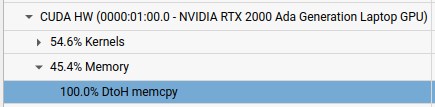

Before we dig into this let's first remind ourselves how memory is managed. Every script begins its execution on the host machine. Data resides in the host's RAM, from where the CPU can fetch it via high throughput buses and perform calculations. If the script utilizes the GPU then the data needs to be copied to the GPU's VRAM. In the context of CUDA the CPU-RAM combination is referred to as the 'host', while the GPU-VRAM is called the 'device', while copy operations that transfer data between the host and device (or between devices) are commonly referred to as 'memcpy'. 

In the picture only device to host data transfers are listed (*100% DtoH memcpy*), but from what we've said till now there should be at least a small percentage also listed for the transfer that happens from host to device. Why is that not the case here? We would need to additionally confirm this, but from our understanding it seems that lazy conversions performed by CuPy (in regard to NumPy data it receives – look up the line *summed = cp.sum(squared)* in the script) aren't captured under memcpy, at least not at the level shown in the traces. This would also explain why DeviceReduceSingleTileKernel (CuPy's reduction kernel – used for computing things like sum, max, min etc. across a single block) isn't listed under kernel operations. The timeline clearly shows only one kernel (*cupy_sqrt_float_float32*) being launched inside one iteration (the end of which is represented by the device to host transfer seen on the right):

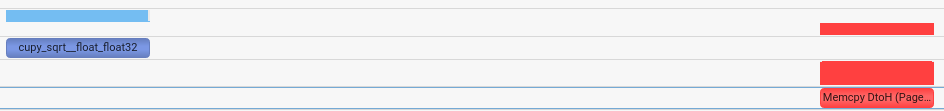

Now let's have a look at traces of the other version of our script, that receives as input CuPy arrays (see './cupy_input.py'). We find that in this case there indeed are four kernel launches per iteration:

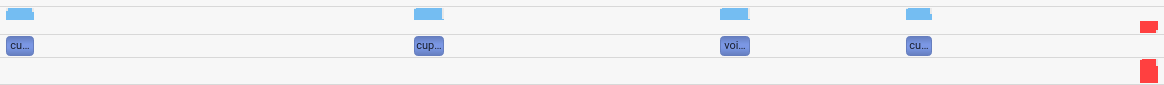

All four operations inside the distance function are performed on the GPU (no lazy conversion needed since all data is copied to VRAM first).
Conversely, contrary to the first script, all four operations are listed under the types of kernels that are launched during execution:

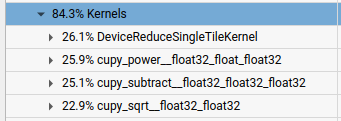

When our script starts a host to device copying of the data is performed (a result of *cp.load()*) which is indicated by a green block close to the start of the timeline.

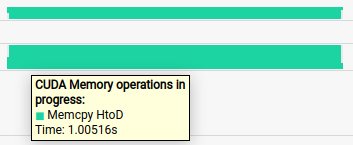

Let's try to make small modifications to our script with which we'll ensure that the GPU is better utilized and which should result in the execution time being shorter than the one we achieved passing NumPy array input.

## Optimizing data transfers: Using pinned memory instead of pageable memory 

We can optimize the device to host data transfers by changing the destination memory type from pageable to pinned. Pageable memory is a problem because CUDA cannot directly access it from the GPU. The OS can swap the pageable memory to disk if needed, so the memory isn't guaranteed to stay in RAM. It must first internally allocate a temporary pinned buffer into which it copies the data and then initiate the transfer from this pinned host  to the pageable host memory. This introduces extra latency and CPU-side bandwidth usage as we need to perform two copies of the same data just to perform the transfer. By making the memory pinned (i.e. page-locked) the GPU can directly access the memory (which is locked in physical RAM, i.e., can't be swapped by the OS) which removes the need of the extra copy step, enabling faster and more predictable transfers.

In [ ]:
DTYPE = np.float32
DTYPE_SIZE = np.dtype(DTYPE).itemsize

# Allocate a pinned memory buffer to reuse across iterations
# It will store just one float32 value
pinned_buffer = cp.cuda.alloc_pinned_memory(DTYPE_SIZE)
pinned_array = np.frombuffer(pinned_buffer, dtype=DTYPE)

def l2_distance(data, query):
    diff = data - query
    squared = diff ** 2
    summed = cp.sum(squared)
    dist = cp.sqrt(summed)
    return dist

def get_distance(item):
    return item[0]

def knn_search_pinned_memory(X_data, query, k=3):
    distances = []

    for i in range(len(X_data)):
        dist = l2_distance(X_data[i], query)
        # Copy scalar value from GPU to pinned memory using async DtoH memcpy
        cp.cuda.runtime.memcpyAsync(
            pinned_array.ctypes.data,
            dist.data.ptr,
            dist.nbytes,
            # Specify the direction of the copy
            2,
            cp.cuda.Stream.null.ptr
        )
        cp.cuda.Stream.null.synchronize()  # Ensure the copy is finished before accessing

        distances.append((pinned_array[0], i))
    distances.sort(key=get_distance)
    top_k = distances[:k]
    indices = []
    
    for item in top_k:
        _, idx = item
        indices.append(idx)
    return indices

In [ ]:
cp.cuda.Device(0).synchronize()
start = cp.cuda.Event()
end = cp.cuda.Event()
start.record()

top_matches = knn_search_pinned_memory(doc_embeddings_gpu, query_embedding_gpu, k=3)

end.record()
cp.cuda.Device(0).synchronize()

elapsed_time_ms = cp.cuda.get_elapsed_time(start, end)
print(f"KNN CuPy loop-based, pinned memory version took {elapsed_time_ms:.2f} ms")
# Sanity check that will be present across different versions of our scripts
print(f"Top matches: {top_matches}")

KNN CuPy loop-based, pinned memory version took 4814.33 ms
Top matches: [21261, 18864, 12709]


We see we get a small, but noticeable improvement. Let's compare what are the average throughput
and bandwidth values across all the data transfers between the version of the program that uses pageable memory (see './scripts/cupy_array_input.py') and the one that uses pinned memory (see './scripts/pinned_mem.py'). To do this we export all statistics of the traces files into an SQLite database using the command *nsys stats*. We then run two queries:

`1) Get average throughput`
```sql
-- We multiply by 1.0 to promote the entire expression to float,
-- multiply by 1e9 to convert nanoseconds to seconds,
-- divide by 1024 * 1024 to convert bytes/sec to mebibytes (MiB)
SELECT AVG(1.0 * bytes / (end - start)) * 1e9 / (1024 * 1024) AS avg_throughput_MiBs
FROM CUPTI_ACTIVITY_KIND_MEMCPY
WHERE copyKind = 2 AND (end - start) > 0;
-- Result using pinned memory
3.59478274030985
-- Result using pageable memory
3.60948021553307
```
`2) Get average latency`
```sql
-- We divide by 1000 to convert nanoseconds to microseconds
SELECT AVG(end - start) / 1000 AS avg_latency_ns
FROM CUPTI_ACTIVITY_KIND_MEMCPY
WHERE copyKind = 2;
-- Result using pinned memory
1.06272481333333
-- Result using pageable memory
1.05841092
```
This can seem as a surprise. Although the execution times measured above showed clear improvements when using pinned
memory, statistics show that version of the script using the latter actually has lower throughput and higher latency than the script which doesn't use pinned memory. The cause of this
is the tiny size of the transfers, which is 4 bytes each. The actual memory copying time is negligible for such small sizes, so we can regard the recorded times in the traces being mostly about the fixed overhead 
of setup, scheduling etc. We can partially confirm this by looking at the throughput of the largest data transfer that is measured when data is loaded from host to device`*` and better represents the speeds of data transfer that can be achieved using pinned memory:

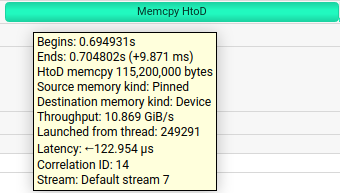

`*` Note that this happens regardless if we are using pinned memory or not for the device to host transfer; In the SQL queries above only transfers in the latter direction were taken into account (the *copyKind* for device to host transfers is '1').

Let's see what speeds do we get when forcing a full copy of the data in the direction from device to host, using pageable memory (see './scripts/pageable_mem_bulk_copy.py'):

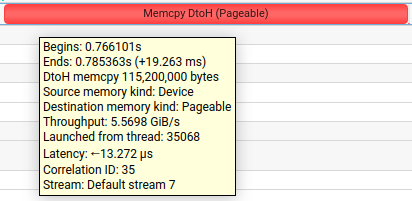

We can see in the above picture that latency is indeed lower (i.e., it takes less to start the transfer), but once the transfer starts, data is being moved at a rate that is nearly half times slower than when using pinned memory, resulting in a more than 9 ms gain overall.

But since in our knn_search_pinned_memory script the device to host transfers are all to small to make much of a difference, why then do we still see an improvement in using pinned memory? Answer lies in comparing these two pictures:

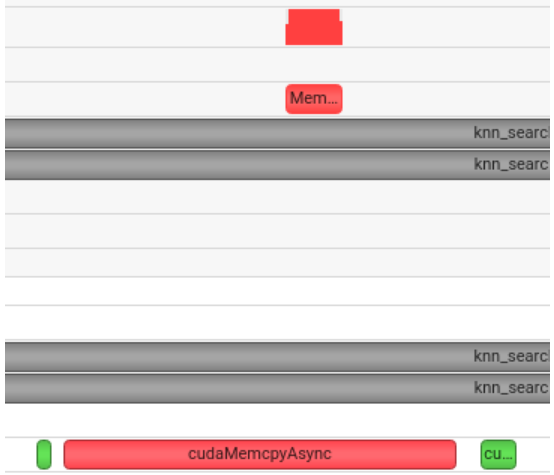 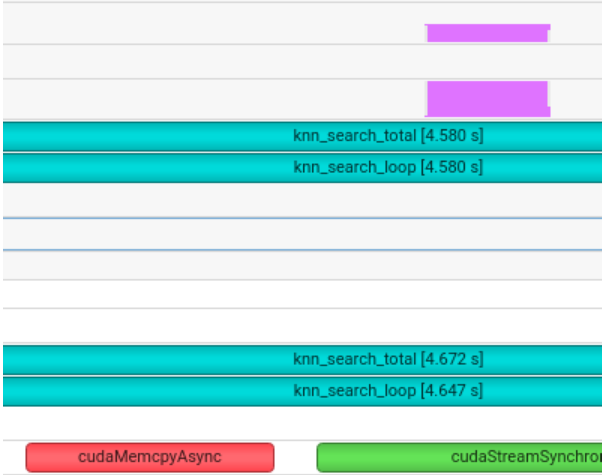

On the one on the right (pinned memory example) we see that each call to cudaMemcpyAsync introduces real
async behaviour, since the execution of the command (red block at the bottom) finishes quickly`*`,
and the actual copying of data (purple block at the top) is performed at a slightly later time.
Let's take a look at the other picture. The call to
cudaMemcpyAsync doesn't terminate until the data transfer (red block at the top) finishes, meaning
the async command doesn't lead to truly asynchronous behaviour.

`*`The two pictures are taken from
different zoom levels so be careful not to interpret the sizes of the blocks as indicating execution time.

This is due to the fact that using pageable memory can (and in our case does) introduce blocking behaviour:
because of pageable memory not providing adequate access guarantees, host-thread synchronization has to be performed, where the CPU (host) thread that launches a CUDA operation waits
for the CUDA task (memory transfer) to finish before continuing with the next instruction.
This blocking behaviour should result in longer cudaMemcpyAsync command execution times. Let's try to confirm this by
again comparing the averages between both types of scripts for executing the command, along with the cumulative:

```sql
-- Get average and cumulative duration of async call
SELECT
  s.value AS api_name,
  1.0 * AVG(r.end - r.start) / 1000 AS avg_duration_us,
  1.0 * SUM(r.end - r.start) / 1000000 AS total_duration_sec
FROM CUPTI_ACTIVITY_KIND_RUNTIME r
JOIN StringIds s ON r.nameId = s.id
WHERE s.value LIKE '%Memcpy%'
GROUP BY s.value
ORDER BY total_duration_sec DESC;
/* name of cuda runtime function called|avg time (in microseconds) the host spent in each call to the function|total cumulative time (in seconds) host spent in cudaMemcpyAsync across all calls */
-- Result using pinned memory
cudaMemcpyAsync_v3020|2.34491861550359|175.873586
-- Result using pageable memory
cudaMemcpyAsync_v3020|7.62246209434415|571.699902
```

This time round we've found a measure that also statistically confirms the better runtime performance of the
memory pinned version of our script - average and cumulative duration of async calls is more than 3x longer when using pageable memory.

## Optimising computations

The optimization above was related to memory transfers. While we achieved some performance gain, this wasn't
enough to make bigger impact on the code execution times.
We plan to achieve this goal by changing the way computations are performed`*`.

`*` To focus on the latter and keep our examples as clear as possible
(also considering the gains from the previous optimization not to be crucial in our use case) we decided to leave out the pinned memory optimization in the
examples that remain.

We will proceed in three steps, in the first one getting rid of
calculating the l2_distances separately for each dataset vector and instead perform them in one go.

### Vectorization

In [1]:
def knn_search_step1_vectorize_distances(X_data, query, k=3):
    # Vectorized l2 computation across all rows
    diff = X_data - query  # broadcasted
    squared = diff ** 2
    summed = cp.sum(squared, axis=1)  # sum over feature dimensions
    dists = cp.sqrt(summed)           # shape: (n_docs,)

    distances = []
    for i in range(len(dists)):
        d = dists[i]
        distances.append((d.item(), i))  # convert GPU scalar to Python float

    distances.sort(key=get_distance)
    top_k = distances[:k]

    indices = []
    for item in top_k:
        _, idx = item
        indices.append(idx)
    return indices

In [36]:
cp.cuda.Device(0).synchronize()
start = cp.cuda.Event()
end = cp.cuda.Event()
start.record()

top_matches = knn_search_step1_vectorize_distances(doc_embeddings_gpu, query_embedding_gpu, k=3)

end.record()
cp.cuda.Device(0).synchronize()

elapsed_time_ms = cp.cuda.get_elapsed_time(start, end)
print(f"KNN CuPy loop-based version took {elapsed_time_ms:.2f} ms")
print(f"Top matches: {top_matches}")

KNN CuPy loop-based version took 833.87 ms
Top matches: [21261, 18864, 12709]


There is a noticable improvement. In this step we've made the script execute faster then when part of operations was done on the CPU. Inspecting how our script looks in Nsight
we can see that overall the plethora of kernel functions that were executed in previous script
now boils down to just four instances:

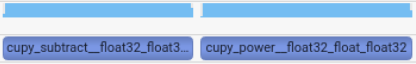 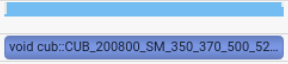 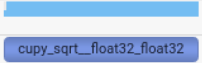

Following this, the Kernels/Memory ratio for CUDA processes has switched
from 84.3%/15.7% to 3.0%/97%.

There is still a lot of room for improvement though. Zooming out we can see what looks like two long red lines being formed after the kernel launches:

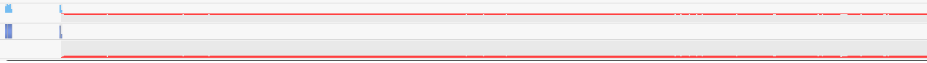

Zooming back in we see they are formed out of separate blocks we encountered before - the calls to cudaMemcpyAsync (red blocks at the bottom), along with the device to host memory transfers (red blocks at the top): 

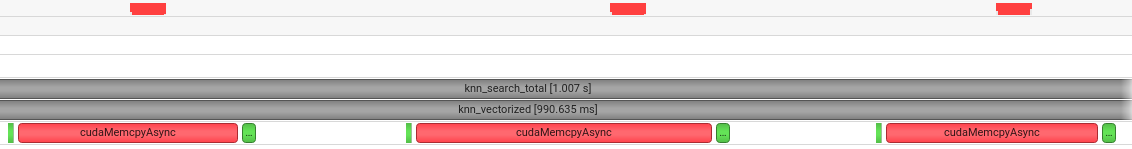

These are the consequence
of conversions from GPU scalars to Python floats, via the .item() method calls. In step 2 we'll get rid of this line of code by using CuPy's
argsort command.

### Efficient sorting

In [ ]:
def knn_search_step2_vectorize_topk(X_data, query, k=3):
    diff = X_data - query
    squared = diff ** 2
    summed = cp.sum(squared, axis=1)
    dists = cp.sqrt(summed)

    # Avoid Python sort: use CuPy argsort instead
    top_k_indices = cp.argsort(dists)[:k]  # still on GPU

    return top_k_indices.tolist()

In [33]:
cp.cuda.Device(0).synchronize()
start = cp.cuda.Event()
end = cp.cuda.Event()
start.record()

top_matches = knn_search_step2_vectorize_topk(doc_embeddings_gpu, query_embedding_gpu, k=3)

end.record()
cp.cuda.Device(0).synchronize()

elapsed_time_ms = cp.cuda.get_elapsed_time(start, end)
print(f"KNN CuPy loop-based version took {elapsed_time_ms:.2f} ms")
print(f"Top matches: {top_matches}")

KNN CuPy loop-based version took 3.31 ms
Top matches: [21261, 18864, 12709]


This script performs much better than the previous one! Checking the report we can see the long "line" of memory transfers is gone,
which is the main contributor for faster speed of execution.
Compared to previous script version the relative percentage of kernel launches has increased (from 3.0% to 22.3%), although this isn't solely due to changed memory transfers but also because the newly introduced sorting operation is quite expensive to compute. Let's take a closer look at its building blocks:

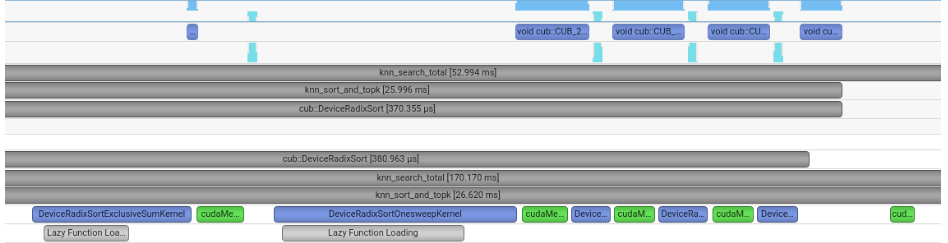

DeviceRadixSortHistogramKernel (not shown on the picture, as it is positioned separately, wider to the left) and DeviceRadixSortExclusiveSumKernel act as setup stage for the other kernels, building histograms of key bits and computing prefix sums that are part of the radix sort process used. The remaining calls are to 
DeviceRadixSortOnesweepKernel, which perform the actual sorting operation in four »sweeps«.

Zooming out we can see this actually isn't our main bottleneck now (the kernels related to radix sort are the ones on the far right of the picture):

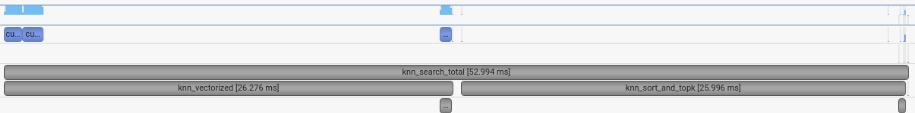

The first four operations kernel launches that appear on the timeline bite much more time out of our script than the sorting ones at the end (there's also a cupy_copy and transform_kernel being launched after the four steps, but we won't focus on them here, since their execution times are negligible compared to the other four).
These represent our last optimisation challenge.
To overcome it we'll resort to using a method called kernel fusion - instead of launching separate kernels
for each operation, we'll combine them into a single GPU kernel.

### Fused operations

In [ ]:
# Fused kernel: computes squared L2 norm in a single kernel
l2_norm_kernel = cp.ElementwiseKernel(
    in_params='raw float32 x, raw float32 y, int32 dim',
    out_params='float32 result',
    operation='''
    float sum = 0.0;
    for (int j = 0; j < dim; ++j) {
        float diff = x[i * dim + j] - y[j];
        sum += diff * diff;
    }
    result = sqrtf(sum);
    ''',
    name='fused_l2_norm'
)

def knn_search_step3_fused(X_data, query, k=3):
    n_rows, n_dims = X_data.shape

    # Allocate output manually so CuPy knows how many times to loop
    d = cp.empty(n_rows, dtype=cp.float32)

    # Call fused kernel with shape
    l2_norm_kernel(X_data.ravel(), query, n_dims, d)

    top_k_indices = cp.argsort(d)[:k]
    return top_k_indices.tolist()

Running the above script (see './scripts/vec_step3_fus.py') and inspecting the traces we can make sure our fused kernel works as intended:

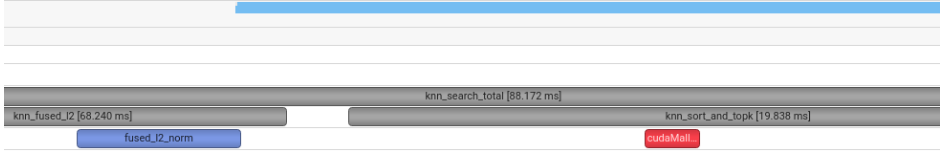

A call to fused_l2_norm is made that results in all four mathematical operations (diff, squared, summed, sqrt) being performed in one kernel execution (as seen at the top of the picture).

As the runtime differences will be smaller now and thus harder to discern doing single runs, we'll run
the newly defined script 10x times and look at the average runtime, then do the same with the previous script.

In [ ]:
import cupy as cp

total_time = 0.0
num_runs = 10
top_matches = None

for i in range(num_runs):
    cp.cuda.Device(0).synchronize()
    start = cp.cuda.Event()
    end = cp.cuda.Event()

    start.record()
    top_matches = knn_search_step3_fused(doc_embeddings_gpu, query_embedding_gpu, k=3)
    end.record()

    cp.cuda.Device(0).synchronize()
    elapsed_time_ms = cp.cuda.get_elapsed_time(start, end)
    total_time += elapsed_time_ms

average_time = total_time / num_runs

print(f"Average runtime over {num_runs} runs: {average_time:.2f} ms")
print(f"Top matches (last run): {top_matches}")


Average runtime over 10 runs: 1.78 ms
Top matches (last run): [21261, 18864, 12709]


In [61]:
import cupy as cp

total_time = 0.0
num_runs = 10
top_matches = None  # store last result for printing

for i in range(num_runs):
    cp.cuda.Device(0).synchronize()
    start = cp.cuda.Event()
    end = cp.cuda.Event()

    start.record()
    top_matches = knn_search_step2_vectorize_topk(doc_embeddings_gpu, query_embedding_gpu, k=3)
    end.record()

    cp.cuda.Device(0).synchronize()
    elapsed_time_ms = cp.cuda.get_elapsed_time(start, end)
    total_time += elapsed_time_ms

average_time = total_time / num_runs

print(f"Average runtime over {num_runs} runs: {average_time:.2f} ms")
print(f"Top matches (last run): {top_matches}")


Average runtime over 10 runs: 3.05 ms
Top matches (last run): [21261, 18864, 12709]


The average runtimes confirm that the kernel fusion method worked in lowering the runtime even more.
If we would compare our simple script with the cuVS brute_force implementation we would see that the latter
still outperforms our simple implementation by quite a bit (due to additional kernel and memory optimisation techniques)
but overall we can be happy with the results.

## Final thoughts

I hope you learned something new following this notebook. We only scratched the surface here of
what memory and computational optimizations stand for. I am sure you can get to many more interesting findings using the libraries and tools we mentioned, so feel free to change the scripts, play around with different datasets and try to interpret Nsight traces by yourself. 